In [1]:
# run once only
import os
os.chdir("../")
print(os.getcwd())

/home/jakob/repos/dl4aed-ws2223-p2


In [3]:
from avinoise import config, prediction, extraction
import random
import matplotlib.pyplot as plt
import pandas as pd

params = config.params()

model_paths = ["_models/F1M1.h5",
               "_models/F1M2.h5",
               "_models/F2M1.h5",
               "_models/F2M2.h5",]

weights_paths = ["_models/weights_F1M1.h5",
                 "_models/weights_F1M2.h5",
                 "_models/weights_F2M1.h5",
                 "_models/weights_F2M2.h5",]

In [ ]:
from sklearn.metrics import classification_report
from keras.models import load_model
import numpy as np
train_path = os.path.join(params.data_root, "train")
test_path = os.path.join(params.data_root, "test")

for i, model, weight in enumerate(zip(model_paths, weights_paths)):
    if i < 2: # F1 features
        loaded_train, loaded_test = extraction.loadFeatures(train_path, test_path)
    model = load_model(model)
    model.load_weights(weight)
    y_test_prob = model.predict(loaded_test)
    y_test_pred = np.argmax(y_test_prob, axis=1)
    y_test_true = np.argmax(np.array([y for x, y in loaded_test.unbatch().as_numpy_iterator()]), 
                            axis=1)

    print('Classification report:')
    print(classification_report(y_true=y_test_true, y_pred=y_test_pred, target_names=params.classes))


In [3]:
n_samples = 80
samples = random.sample(os.listdir("raw_data/clean/"), n_samples)
clean_data = ["raw_data/clean/" + s for s in samples]
samples = random.sample(os.listdir("raw_data/contaminated/"), n_samples)
contaminated_data = ["raw_data/contaminated/" + s for s in samples]
data = [clean_data, contaminated_data]
labels = ["CLEAN", "CONTAMINATED"]
postp_methods = ["greaterOnce", "greaterMean"]


2023-03-20 20:35:28.620560: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-20 20:35:28.620596: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-20 20:35:28.620614: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jtubuntusrvr): /proc/driver/nvidia/version does not exist
2023-03-20 20:35:28.620804: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


64/80 correct samples for class <CLEAN> with model <_models/F1M1.h5>
66/80 correct samples for class <CONTAMINATED> with model <_models/F1M1.h5>
63/80 correct samples for class <CLEAN> with model <_models/F1M2.h5>
80/80 correct samples for class <CONTAMINATED> with model <_models/F1M2.h5>
64/80 correct samples for class <CLEAN> with model <_models/F2M1.h5>
64/80 correct samples for class <CONTAMINATED> with model <_models/F2M1.h5>
57/80 correct samples for class <CLEAN> with model <_models/F2M2.h5>
73/80 correct samples for class <CONTAMINATED> with model <_models/F2M2.h5>
80/80 correct samples for class <CLEAN> with model <_models/F1M1.h5>
39/80 correct samples for class <CONTAMINATED> with model <_models/F1M1.h5>
80/80 correct samples for class <CLEAN> with model <_models/F1M2.h5>
63/80 correct samples for class <CONTAMINATED> with model <_models/F1M2.h5>
80/80 correct samples for class <CLEAN> with model <_models/F2M1.h5>
30/80 correct samples for class <CONTAMINATED> with model <_m

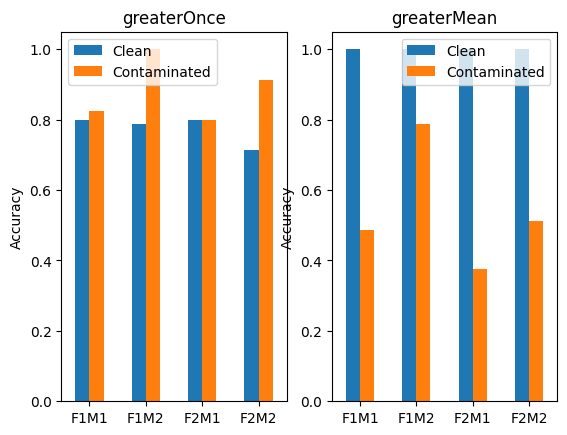

In [4]:
%matplotlib inline

fig, axs = plt.subplots(1, 2)

for n, method in enumerate(postp_methods):

    corrects = []

    for model_path, weights_path in zip(model_paths, weights_paths):

        if "F1" in model_path:
            params.add({"normalize": False})
            params.add({"cutoff": 0})
        else:
            params.add({"normalize": True})
            params.add({"cutoff": 0.01})
            
        for clss, label in zip(data, labels):

            correct = 0
            for file in clss:

                preds, mel = prediction.predict(file, model_path, weights_path)
                if prediction.evaluate(preds, method=method, show_text=False) == label:
                    correct += 1
            corrects.append(correct / n_samples)
            print(f"{correct}/{n_samples} correct samples for class <{label}> with model <{model_path}>")

    cleans = [val for i, val in enumerate(corrects) if i % 2 == 0]
    contaminateds = [val for i, val in enumerate(corrects) if i % 2 != 0]
    index = [name.replace("_models/", "").replace(".h5", "") for name in model_paths]
    df = pd.DataFrame({'Clean': cleans,
                    'Contaminated': contaminateds}, index=index)
    df.plot.bar(rot=0, ax=axs[n])
    axs[n].set_title(method)
    axs[n].set_ylabel("Accuracy")

plt.tight_layout()